In [1]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

In [2]:
from targets.conditional_density_estimation_target import Wave
target = Wave()

N_simulations = 10000
D_theta = target.sample_prior(N_simulations)
D_x = target.simulate(D_theta)

mu_theta = torch.zeros(1)
sigma_theta = torch.eye(1)
theta_prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta)
theta0 = theta_prior_distribution.sample()
theta0 = 0*torch.ones(1)

N_observations = 1
x0 = target.simulate(theta0.unsqueeze(0).repeat(N_observations,1))

In [1]:
plt.figure(figsize = (15,8))
plt.set_xlim = (-8,8)
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
plt.axvline(theta0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0 = ' + str(theta0.item()))
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -8, label = 'histogram of x0', color = 'C1')
plt.axhline(x0.numpy(), color = 'orange', alpha = .7, linestyle = '--', label = 'Observed value of x0')
plt.legend()

NameError: name 'plt' is not defined

In [4]:
alpha = torch.tensor(50.)
truncation = 100
Beta_distribution = torch.distributions.Beta(1, alpha)

In [5]:
def sample_weights(z, z_tilde): 
    Z = torch.cat([z, z_tilde], dim =0)
    counts = torch.unique(Z, return_counts = True)[1]
    probs = torch.cat([counts,alpha.unsqueeze(-1)], dim = -1)
    w = torch.distributions.Dirichlet(probs).sample()
    r = w[-1]
    w_ = w[:-1]
    for i in range(truncation-1):
        v = Beta_distribution.sample()
        w = r*v
        r = r*(1-v)
        w_ = torch.cat([w_,w.unsqueeze(-1)], dim = -1)
    w_ = torch.cat([w_,r.unsqueeze(-1)], dim = -1)
    return w_

In [6]:
d=1
nu = 2
lbda = 0.1
mu = torch.zeros(d)
psi = torch.eye(d)

def sample_prior_parameters_theta(num_samples):
    sigma_theta = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(psi)).sample([num_samples]))
    sigma_theta = (sigma_theta + torch.transpose(sigma_theta, 1,2))/2
    mean_theta = torch.distributions.MultivariateNormal(mu,scale_tril = torch.cholesky(sigma_theta)/(lbda**(1/2))).sample()
    return mean_theta, sigma_theta

mu_beta = torch.zeros(d+1)
sigma_beta = torch.eye(d+1)
eta = 2
phi  = torch.eye(d)

def sample_prior_parameters_x(num_samples):
    sigma_x = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(psi)).sample([num_samples]))
    beta = torch.distributions.MultivariateNormal(mu_beta, sigma_beta).sample([num_samples])
    return beta, sigma_x
    
def repopulate_parameters(mean_theta, sigma_theta, beta, sigma_x):
    _mean_theta, _sigma_theta = sample_prior_parameters_theta(truncation)
    mean_theta = torch.cat([mean_theta, _mean_theta], dim = 0)
    sigma_theta = torch.cat([sigma_theta, _sigma_theta], dim = 0)
    _beta, _sigma_x = sample_prior_parameters_x(truncation)
    beta = torch.cat([beta, _beta], dim = 0)
    sigma_x = torch.cat([sigma_x,_sigma_x], dim=0)
    return mean_theta, sigma_theta, beta, sigma_x

In [7]:
def sample_allocation(w, D_x,D_theta, x0, theta0, mean_theta, sigma_theta, beta, sigma_x): 
    _D_x= torch.cat([D_x, x0], dim=0)
    _D_theta= torch.cat([D_theta, theta0.unsqueeze(-1)], dim = 0)
    w_i_k = w.unsqueeze(0).repeat(_D_x.shape[0],1)
    p_i_k_theta = torch.exp(torch.distributions.MultivariateNormal(mean_theta, sigma_theta).log_prob(_D_theta.unsqueeze(1).repeat(1,w.shape[0],1)))
    temp_mean = (torch.cat([_D_theta, torch.ones(_D_theta.shape[0],1)], dim =1)@beta.T).unsqueeze(-1)
    temp_sigma_x =  sigma_x.unsqueeze(0).repeat(_D_x.shape[0],1,1,1)
    temp_x = _D_x.unsqueeze(1).repeat(1, w.shape[0],1)
    p_i_k_x_theta = torch.exp(torch.distributions.MultivariateNormal(temp_mean,temp_sigma_x).log_prob(temp_x))
    temp = w_i_k*p_i_k_theta*p_i_k_x_theta
    sample = torch.distributions.Categorical(temp/ torch.sum(temp, dim = -1).unsqueeze(-1)).sample()
    return sample[:D_x.shape[0]], sample[D_x.shape[0]:]

In [8]:
def equivalent_allocation(z,z_tilde,mean_theta, sigma_theta, beta, sigma_x):
    _z = torch.cat([z,z_tilde], dim = 0)
    unique, inverse_index = torch.unique(_z, return_inverse = True)
    new_mean_theta = mean_theta[unique]
    new_sigma_theta = sigma_theta[unique]
    new_beta = beta[unique]
    new_sigma_x = sigma_x[unique]
    return inverse_index[:z.shape[0]],inverse_index[z.shape[0]:], new_mean_theta, new_sigma_theta, new_beta, new_sigma_x

In [14]:
mu_phi = torch.zeros(d+1)
sigma_phi = 10*torch.eye(d+1)

def sample_parameter_posterior(z,z_tilde,D_x, D_theta, x0, theta0):
    _z = torch.cat([z,z_tilde], dim =0)
    _D_x= torch.cat([D_x, x0], dim=0)
    _D_theta= torch.cat([D_theta, theta0.unsqueeze(-1)], dim = 0)
    list_cov_theta = []
    list_mean_theta = []
    list_beta = []
    list_cov_x = []
    for c in torch.unique(_z):
        _D_x_c = _D_x[_z==c]
        _D_theta_c = _D_theta[_z==c]
        N_c = _D_x_c.shape[0]
        ###Posterior on mean_theta, sigma_theta
        empirical_mean_theta = torch.mean(_D_theta_c, dim =0)
        mu_c = (lbda*mu + N_c*empirical_mean_theta)/(lbda + N_c)
        S = torch.cov(_D_theta_c.T)*(N_c-1) if N_c>=2 else torch.zeros(d)
        temp = (empirical_mean_theta-mu).unsqueeze(-1)
        Psi_c = psi + S + (lbda*N_c*temp@temp.T)/(lbda + N_c)
        cov_theta_c = torch.inverse(torch.distributions.Wishart(nu + N_c,torch.inverse(Psi_c)).sample())
        cov_theta_c = (cov_theta_c + torch.transpose(cov_theta_c,0,1))/2
        mean_theta_c = torch.distributions.MultivariateNormal(mu_c, scale_tril = torch.cholesky(cov_theta_c)/((lbda + N_c)**(1/2))).sample()
        list_cov_theta.append(cov_theta_c.unsqueeze(0))
        list_mean_theta.append(mean_theta_c.unsqueeze(0))
        
        empirical_mean_x = torch.mean(_D_x_c, dim =0)
        mu_c = (lbda*mu + N_c*empirical_mean_x)/(lbda + N_c)
        S = torch.cov(_D_x_c.T)*(N_c-1) if N_c>=2 else torch.zeros(d)
        temp = (empirical_mean_x-mu).unsqueeze(-1)
        Psi_c = psi + S + (lbda*N_c*temp@temp.T)/(lbda + N_c)
        cov_x_c = torch.inverse(torch.distributions.Wishart(nu + N_c,torch.inverse(Psi_c)).sample())
        list_cov_x.append(cov_x_c.unsqueeze(0))
        if _D_theta_c.shape[0]>=2:
            temp = torch.cat([_D_theta_c, torch.ones(_D_theta_c.shape[0]).unsqueeze(-1)], dim = -1)
            sigma_d_phi = torch.inverse(temp.T@temp)*cov_x_c[0,0]
            mu_d_phi = _D_x_c.squeeze(-1)@temp@torch.inverse(temp.T@temp)
            if _D_theta_c.shape[0]>=2:
                sigma_phi_d = torch.inverse(torch.inverse(sigma_d_phi) + torch.inverse(sigma_phi))
                mu_phi_d = sigma_phi_d@(torch.inverse(sigma_d_phi)@mu_d_phi+ torch.inverse(sigma_phi)@mu_phi)
            else:
                temp = torch.cat([_D_theta_c, torch.ones(_D_theta_c.shape[0]).unsqueeze(-1)], dim = -1)
                sigma_phi_d = torch.inverse(temp.T@temp/cov_x_c[0,0] + torch.inverse(sigma_phi))
                mu_phi_d = sigma_phi_d@(_D_x_c.squeeze(-1)@temp/cov_x_c[0,0]+ torch.inverse(sigma_phi)@mu_phi)
        else: 
            mu_phi_d, sigma_phi_d = mu_phi, sigma_phi
        beta_c = torch.distributions.MultivariateNormal(mu_phi_d, sigma_phi_d).sample()
        
        list_beta.append(beta_c.unsqueeze(0))
    return torch.cat(list_mean_theta, dim = 0), torch.cat(list_cov_theta, dim = 0), torch.cat(list_beta, dim =0), torch.cat(list_cov_x, dim = 0)

In [15]:
from IPython.display import clear_output
def plot_all(z, z_tilde, D_x, D_theta,x0, theta0,mean_theta, sigma_theta, beta, sigma_x):
    plt.figure(figsize = (10,10))
    plt.scatter(D_theta.squeeze(-1).numpy(), D_x.squeeze(-1).numpy(), c=z, cmap = matplotlib.cm.get_cmap('plasma'), alpha = .5)
    plt.scatter(theta0, x0, color = 'green')

def joint_log_prob(z, z_tilde,mean_theta, sigma_theta, beta, sigma_x, X, Theta):
    _z = torch.cat([z,z_tilde], dim=0)
    unique, count = torch.unique(_z, return_counts = True)
    weights = count/_z.shape[0]
    prob_theta = torch.exp(torch.distributions.MultivariateNormal(mean_theta, sigma_theta).log_prob(Theta.unsqueeze(1).repeat(1,mean_theta.shape[0],1)))
    mean_x = (beta@torch.cat([Theta, torch.ones(Theta.shape[0],1)], dim = 1).T).unsqueeze(-1)
    cov_x = sigma_x.unsqueeze(1).repeat(1,Theta.shape[0],1,1)
    temp_input = X.unsqueeze(1).repeat(1,mean_theta.shape[0],1).unsqueeze(2).repeat(1,1,Theta.shape[0],1)
    prob_x = torch.exp(torch.distributions.MultivariateNormal(mean_x, cov_x).log_prob(temp_input))
    product_prob = prob_theta.T.unsqueeze(0)*prob_x
    sum_weighted_prod = torch.sum(weights.unsqueeze(0).unsqueeze(-1)*product_prob, dim = 1)
    return sum_weighted_prod

In [16]:
mu_theta0 = torch.zeros(d)
sigma_theta0 = 10*torch.eye(d)
def sample_posterior(z_tilde, x0, beta, sigma_x, num_samples = None):
    beta_c = beta[z_tilde.item()]
    sigma_x_c = sigma_x[z_tilde.item()]
    sigma_theta_x0_phi = torch.inverse(torch.inverse(sigma_theta0) + (x0.shape[0]*beta_c[0]**2)/sigma_x_c[0,0])
    temp = sigma_theta_x0_phi@(torch.inverse(sigma_theta0)@mu_theta0)
    mu_theta_x0_phi = sigma_theta_x0_phi@(torch.inverse(sigma_theta0)@mu_theta0 + beta_c[0]*torch.sum(x0.squeeze(-1) - beta_c[1])/sigma_x_c[0,0])
    if num_samples is None:
        return torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
    else: return torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample([num_samples])

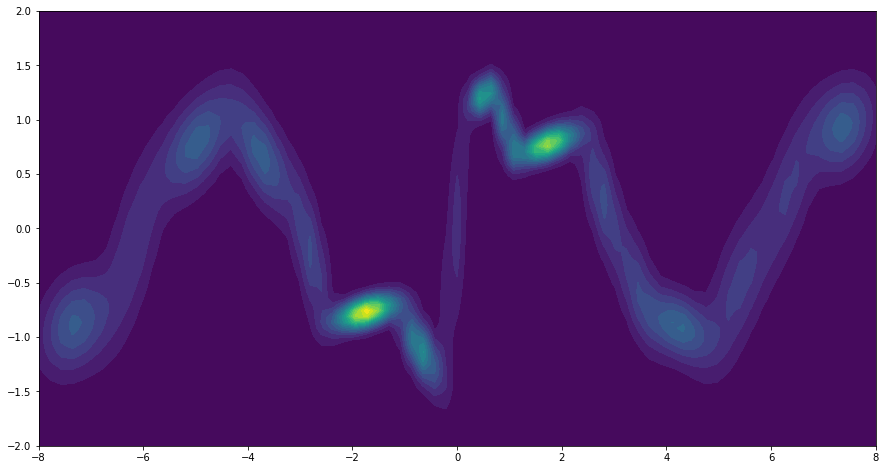

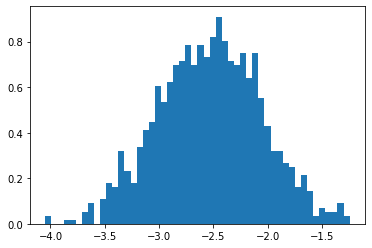

torch.Size([27, 1])


In [ ]:
number_gibbs_iterations = 1
z = torch.ones(N_simulations)
mean_theta, sigma_theta = sample_prior_parameters_theta(1)
beta, sigma_x = sample_prior_parameters_x(1)
z_tilde = torch.ones(N_observations)
theta0 = theta_prior_distribution.sample()
list_theta = []
for i in range(1000):
    w = sample_weights(z,z_tilde)
    mean_theta, sigma_theta, beta, sigma_x = repopulate_parameters(mean_theta, sigma_theta, beta, sigma_x)
    z, z_tilde = sample_allocation(w, D_x, D_theta, x0, theta0, mean_theta, sigma_theta, beta, sigma_x)
    z,z_tilde, mean_theta, sigma_theta, beta, sigma_x = equivalent_allocation(z,z_tilde, mean_theta, sigma_theta, beta, sigma_x)
    mean_theta, sigma_theta, beta, sigma_x = sample_parameter_posterior(z,z_tilde, D_x, D_theta, x0, theta0)
    theta0 = sample_posterior(z_tilde, x0, beta, sigma_x)
    bunch_of_theta0 = sample_posterior(z_tilde, x0, beta, sigma_x, num_samples = 1000)
    clear_output(wait = True)
    plt.figure(figsize = (15,8))
    prob = joint_log_prob(z, z_tilde,mean_theta, sigma_theta, beta, sigma_x, torch.linspace(-2,2,75).unsqueeze(-1), torch.linspace(-8,8,75).unsqueeze(-1))
    plt.contourf( torch.linspace(-8,8,75),torch.linspace(-2,2,75), prob, levels = 20)
    plt.show()
    list_theta.append(theta0)
    hist = plt.hist(bunch_of_theta0.numpy(), density = True, bins = 50)
    plt.show()
    print(mean_theta.shape)
    